# Innovative Technologien und Services
### von Fabian Harmsen, Phillip Krumpholz, Till Waller
### Recommenderservice mit Python
Ziel dieser Abgabe ist es ein funktionierendes Recommenders system zu entwickeln, welches contend-based und collaborative filtering ermöglicht.


### Imports für den Recommender
Im folgenden Abschnitt werden Bibiliotheken für den Recommender importiert.

In [412]:
import pandas as pd
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split, cross_validate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## Aufgabe 1
Im folgenden Abschnitt wird der Aufbau des contend-basted Recommenders Schritt für Schritt erläutert. Zum Abschluss werden einige Empfehlungen zu bestimmten Filmen exemplarisch ausgegeben.

### Import der CSV "metadata"
Im folgenden Abschnitt importieren wir die CSV-Dateien. Hierbei ist zu erwähnen das Filme aus der metadata.csv nicht die gleichen Filme enthalten wie die ratings_small.csv. Dies liegt daran, dass die metadata.csv den aktuellen Katalog an Filmen enthält, die ratings_small.csv hingegen alle Filme die jemals auf der Plattform waren und bewertet wurden.

In [413]:
metadata = pd.read_csv('data/movies_metadata.csv', low_memory=False)
credits = pd.read_csv('data/credits.csv', low_memory=False)
keywords = pd.read_csv('data/keywords.csv', low_memory=False)
rating = pd.read_csv('data/ratings_small.csv', low_memory=False)

### Content based filtering und das Problem dahinter
Jeder Film hat eine Beschreibung welche wir im folgenden Abschnitt einmal exemplarisch zeigen. Das offensichtliche Problem hierbei ist die automatische Verarbeitung von natürlicher Sprache.

In [414]:
metadata.head(3)
metadata['overview'].head()

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: overview, dtype: object

### Lösung des Problems
Um natürliche Sprache richtig zu verarbeiten, vektorizieren wir alle Wörter jeder Beschreibung. Durch die Vektorisierung der Wörter und der Bildung einer Matrix, ist es nun möglich Beschreibungen anhand der Kosinus-Ähnlichkeit (cosine similarity) zu berechnen. Somit können nun Beschreibungen miteinander verglichen werden.


### Recommender anhand von Beschreibungen
Die Funktion getCosineMatrixDescription nimmt einen DataFrame mit Metadaten als Eingabe und gibt eine Matrix zurück. Die Funktion führt folgende Schritte aus:

Die Spalte "overview" des DataFrames wird vektorisiert und in eine Matrix umgewandelt, indem das TfidfVectorizer-Objekt verwendet wird. Dieser Vektorisierungsvorgang besteht darin, jedes Dokument (in diesem Fall die Übersicht eines Films) in Vektorform darzustellen, indem die Häufigkeit von jedem Wort im Dokument berücksichtigt wird. Das TfidfVectorizer-Objekt verwendet außerdem die Angabe "english" als Stopworte, um bestimmte häufig vorkommende Wörter wie "the" und "a" zu ignorieren.
Die Matrix, die durch die Vektorisierung der Übersichten erhalten wurde, wird dann mit der Funktion linear_kernel mit sich selbst multipliziert, um eine Matrix mit Ähnlichkeitswerten zwischen allen Dokumenten (Übersichten) zu erhalten. Diese Ähnlichkeitswerte werden als Cosinusähnlichkeit berechnet, wodurch die Ähnlichkeit zwischen zwei Dokumenten anhand des Winkels gemessen wird, der zwischen ihren Vektoren entsteht.
Die Cosinusähnlichkeitsmatrix wird schließlich als Rückgabewert der Funktion zurückgegeben.




In [415]:
def getCosineMatrixDescription(metadata):
    # Vektorisieren der Beschreibung
    tfidf = TfidfVectorizer(stop_words='english')
    metadata['overview'] = metadata['overview'].fillna('')
    tfidf_matrix = tfidf.fit_transform(metadata['overview'])

    # Bildung der Matrix
    cosine_matrix = linear_kernel(tfidf_matrix, tfidf_matrix)
    return cosine_matrix

### Hilfsfunktion get_director
Die Funktion get_director nimmt eine Liste von dictionaries als Eingabe und gibt den Namen eines Regisseurs zurück. Die Funktion führt folgende Schritte aus:

Die Funktion iteriert über jedes Dictionary in der Liste.
Wenn das Dictionary einen Eintrag mit dem Schlüssel "job" hat, der den Wert "Director" enthält, wird der Wert des Schlüssels "name" des Dictionarys zurückgegeben.
Wenn kein Dictionary gefunden wird, das den Wert "Director" für den Schlüssel "job" enthält, wird der Wert np.nan (Not a Number) zurückgegeben.

In [416]:
def get_director(x):
        for i in x:
            if i['job'] == 'Director':
                return i['name']
        return np.nan

### Hilfsfunktion get_list
Die Funktion get_list nimmt eine Liste von dictionaries als Eingabe und gibt eine Liste von Namen zurück. Die Funktion führt folgende Schritte aus:

Die Funktion überprüft, ob die Eingabe eine Liste ist. Wenn dies nicht der Fall ist, wird eine leere Liste zurückgegeben.
Wenn die Eingabe eine Liste ist, wird eine neue Liste erstellt, die die Namen aller Personen enthält, die in der Eingabelisten enthalten sind. Dies wird durchgeführt, indem für jedes Dictionary in der Liste der Wert des Schlüssels "name" extrahiert wird.
Wenn die neu erstellte Liste mehr als drei Elemente enthält, wird die Liste auf die ersten drei Elemente gekürzt. Andernfalls wird die gesamte Liste zurückgegeben.

In [417]:
def get_list(x):
        if isinstance(x, list):
            names = [i['name'] for i in x]
            # Prüfe auf mehr als drei Elemente, wenn mehr nimm die ersten drei, wenn weniger nimm alle
            if len(names) > 3:
                names = names[:3]
            return names

        # Falls keine oder unvolständige Daten gib leere Liste
        return []

### Hilfsfunktion clean_data
Die Funktion clean_data nimmt eine Liste von Namen oder einen einzelnen Namen als Eingabe und gibt eine Liste von Namen oder einen einzelnen Namen zurück, bei denen alle Buchstaben in Kleinbuchstaben umgewandelt und alle Leerzeichen entfernt wurden. Die Funktion führt folgende Schritte aus:

Die Funktion überprüft, ob die Eingabe eine Liste ist. Wenn dies der Fall ist, wird eine neue Liste erstellt, die die Namen aller Personen enthält, die in der Eingabelisten enthalten sind. Dies wird durchgeführt, indem für jedes Element in der Liste die folgenden Operationen durchgeführt werden:
Alle Buchstaben werden in Kleinbuchstaben umgewandelt, indem die str.lower-Funktion verwendet wird.
Alle Leerzeichen werden entfernt, indem der replace-Methodenaufruf verwendet wird.
Wenn die Eingabe keine Liste ist, wird überprüft, ob es sich um eine Zeichenkette handelt. Wenn dies der Fall ist, werden die gleichen Operationen wie in Schritt 1 durchgeführt und der bearbeitete Name wird zurückgegeben.
Wenn die Eingabe weder eine Liste noch eine Zeichenkette ist, wird eine leere Zeichenkette zurückgegeben.

In [418]:
def clean_data(x):
        if isinstance(x, list):
            return [str.lower(i.replace(" ", "")) for i in x]
        else:
            # Prüfe ob es gibt sonst leerer String
            if isinstance(x, str):
                return str.lower(x.replace(" ", ""))
            else:
                return ''

### Metadaten für den Filter
Die Funktion create_keys nimmt ein Dictionary als Eingabe und gibt eine Zeichenkette zurück, die aus verschiedenen Informationen aus dem Dictionary zusammengesetzt ist. Die Funktion führt folgende Schritte aus:

Die Funktion erstellt eine neue Zeichenkette, indem sie den Wert des Schlüssels "keywords" des Dictionarys mit Leerzeichen zwischen den einzelnen Keywords verbindet.
Die Funktion fügt dann den Wert des Schlüssels "cast" des Dictionarys hinzu, indem sie die Namen aller Schauspieler mit Leerzeichen zwischen den Namen verbindet.
Die Funktion fügt den Wert des Schlüssels "director" des Dictionarys hinzu.
Die Funktion fügt schließlich den Wert des Schlüssels "genres" des Dictionarys hinzu, indem sie die Namen aller Genres mit Leerzeichen zwischen den Namen verbindet.
Die Funktion gibt die zusammengesetzte Zeichenkette schließlich als Rückgabewert zurück.

In [419]:
def create_keys(x):
        # Auswahl der Daten welche beachtet werden sollen
        return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])

### Recommender anhand von ausgewählten Metadaten
Die Funktion getCosineMatrixAttributes nimmt zwei DataFrames (metadata und keywords) und ein Dictionary (credits) als Eingabe und gibt eine Matrix zurück. Die Funktion führt folgende Schritte aus:

Die Spalte "id" in den DataFrames keywords und metadata wird in Integer umgewandelt, indem die astype-Methode verwendet wird. Das Dictionary credits enthält bereits Integer-Werte für die Spalte "id".
Die DataFrames credits und keywords werden mit dem DataFrame metadata mithilfe der merge-Funktion verbunden, wobei die Spalte "id" als gemeinsamen Schlüssel verwendet wird.
Die Funktion definiert eine Liste von Features, die für die weitere Verarbeitung verwendet werden sollen: "cast", "crew", "keywords" und "genres".
Für jedes Feature in der Liste wird der apply-Methodenaufruf verwendet, um die literal_eval-Funktion auf den Wert des Features im DataFrame metadata anzuwenden. Diese Funktion analysiert einen String und gibt eine Liste zurück, wenn der String in Python-Listensyntax gegeben wurde.
Ein neues Feature mit dem Namen "director" wird im DataFrame metadata erstellt, indem der apply-Methodenaufruf verwendet wird, um die Funktion get_director auf den Wert des Features "crew" anzuwenden.
Die Funktion definiert erneut eine Liste von Features: "cast", "keywords" und "genres". Für jedes Feature in der Liste wird der apply-Methodenaufruf verwendet, um die Funktion get_list auf den Wert des Features im DataFrame metadata anzuwenden.
Die Funktion definiert erneut eine Liste von Features: "cast", "keywords", "director" und "genres". Für jedes Feature in der Liste wird der apply-Methodenaufruf verwendet, um die Funktion clean_data auf den Wert des Features im DataFrame metadata anzuwenden.
Ein neues Feature mit dem Namen "keys" wird im DataFrame metadata erstellt, indem der apply-Methodenaufruf verwendet wird, um die Funktion create_keys auf jede Zeile des DataFrames anzuwenden.
Ein CountVectorizer-Objekt wird erstellt und auf das Feature "keys" des DataFrames metadata angewendet, um eine Matrix mit Häufigkeitszählungen der einzelnen Wörter zu erhalten.

In [420]:
def getCosineMatrixAttributes(metadata, keywords, credits):
    # IDs zu Integers für den merge
    keywords['id'] = keywords['id'].astype('int')
    credits['id'] = credits['id'].astype('int')
    metadata['id'] = metadata['id'].astype('int')

    # Merge credits und keywords zu metadata
    metadata = metadata.merge(credits, on='id')
    metadata = metadata.merge(keywords, on='id')

    features = ['cast', 'crew', 'keywords', 'genres']
    for feature in features:
        metadata[feature] = metadata[feature].apply(literal_eval)

    # Zu betrachtende Metadaten
    metadata['director'] = metadata['crew'].apply(get_director)

    features = ['cast', 'keywords', 'genres']
    for feature in features:
        metadata[feature] = metadata[feature].apply(get_list)

    # clean_data um alles vergleichbar zu machen
    features = ['cast', 'keywords', 'director', 'genres']

    for feature in features:
        metadata[feature] = metadata[feature].apply(clean_data)

    # Voher definierte keys
    metadata['keys'] = metadata.apply(create_keys, axis=1)

    count = CountVectorizer(stop_words='english')
    count_matrix = count.fit_transform(metadata['keys'])

    return cosine_similarity(count_matrix, count_matrix)


### Index-Mapping
Die Funktion index_mapping ist eine pd.Series-Instanz, die aus der Metadaten-Tabelle erstellt wurde. Die pd.Series enthält den Index jedes Films als Wert und den Titel jedes Films als Index. Dies wird erreicht, indem der Index der Metadaten-Tabelle als Wert und der Titel als Index übergeben wird.

Die .drop_duplicates()-Methode wird aufgerufen, um alle Duplikate aus der pd.Series zu entfernen. Wenn mehrere Filme den gleichen Titel haben, wird nur der erste Film in der pd.Series gespeichert.

In [421]:
def getIndexMapping (metadata):
    # Mappen der Namen auf die IDs und entfernen der Duplikate
    index_mapping = pd.Series(metadata.index, index=metadata['title']).drop_duplicates()
    return index_mapping

### Funktion recommend_films
Die Funktion recommend_films nimmt den Titel eines Films, eine Zahl n, eine Cosinusähnlichkeitsmatrix und ein Mapping von Filmtiteln auf Matrixindizes sowie einen DataFrame mit Metadaten als Eingabe und gibt eine Liste von empfohlenen Filmtiteln zurück. Die Funktion führt folgende Schritte aus:

Der Index des Films mit dem angegebenen Titel wird mithilfe des Mapping-Dictionaries ermittelt.
Eine Liste von Tupeln, die den Index und den Cosinusähnlichkeitswert für jeden Film in der Matrix enthalten, wird erstellt.
Die Liste wird nach den Cosinusähnlichkeitswerten sortiert, wobei die höchsten Werte zuerst angezeigt werden.
Die Liste wird auf die ersten n Einträge gekürzt (außer dem ersten Eintrag, da der Cosinusähnlichkeitswert für den Film selbst immer 1 ist).
Eine Liste von Matrixindizes wird aus den Tupeln in der gekürzten Liste erstellt.
Die Liste von Filmtiteln wird aus dem DataFrame metadata anhand der Indizes in der Liste von Matrixindizes erstellt und zurückgegeben.

In [422]:
def recommend_films(title, n, cosine_matrix_description, index_mapping, metadata):
    index = index_mapping[title]

    score = list(enumerate(cosine_matrix_description[index]))

    score = sorted(score, key=lambda x: x[1], reverse=True)

    # n + 1 = Anzhal der Filme für den recommender
    score = score[1:n + 1]

    movie_indices = [i[0] for i in score]

    return metadata['title'].iloc[movie_indices]

### Exemplarische Ausgabe der Empfehlungen (Aufgabe 1)
Die oben gezeigte Funktion zeigt Empfehlungen für Filme basierend auf deren Beschreibung und ihren Metadaten an. Die Funktion führt folgende Schritte aus:

Ein neuer DataFrame df_metadata wird erstellt, indem einige Zeilen aus dem ursprünglichen DataFrame metadata entfernt werden.
Die Cosinusähnlichkeitsmatrix für die Beschreibungen der Filme wird mithilfe der Funktion getCosineMatrixDescription berechnet.
Die Cosinusähnlichkeitsmatrix für die Metadaten der Filme wird mithilfe der Funktion getCosineMatrixAttributes berechnet.
Ein Mapping von Filmtiteln auf Matrixindizes wird mithilfe der Funktion getIndexMapping erstellt.
Die Funktion recommend_films wird aufgerufen, um Empfehlungen für den Film mit dem Titel "The Dark Knight Rises" basierend auf der Cosinusähnlichkeitsmatrix für die Beschreibungen und der Cosinusähnlichkeitsmatrix für die Metadaten zu erhalten. Die Empfehlungen werden für die ersten 10 ähnlichen Filme angezeigt.

In [423]:
# Entfernen von IDs welche fehlerhaft sind
df_metadata = metadata.drop([19730, 29503, 35587])

title = 'The Dark Knight Rises'
cosine_matrix_description = getCosineMatrixDescription(df_metadata)
cosine_matrix_attributes = getCosineMatrixAttributes(df_metadata, keywords, credits)
index_mapping = getIndexMapping(df_metadata)

print('Empfehlungen nach Beschreibung:')
# Ausgabe anhand der Beschreibung
print(recommend_films(title, 10, cosine_matrix_description, index_mapping, metadata))
print('Empfehlungen nach Metadaten:')
# Ausgabe anhand der ausgewählten Metadaten
print(recommend_films(title, 10, cosine_matrix_attributes, index_mapping, metadata))

Empfehlungen nach Beschreibung:
12481                       The Dark Knight
150                          Batman Forever
1328                         Batman Returns
15511            Batman: Under the Red Hood
585                                  Batman
21193             Pussy Riot: A Punk Prayer
9230     Batman Beyond: Return of the Joker
18035                      Batman: Year One
19791                 Indie Game: The Movie
3095           Batman: Mask of the Phantasm
Name: title, dtype: object
Empfehlungen nach Metadaten:
44509                             White Dew
27803    Lightning Bolt: The Power Of Salad
26241                   Wicked as They Come
24174                                Spasmo
25865                    Terminator Genisys
32020                         The Scapegoat
23166                  When Jews Were Funny
23294                      Age of Dinosaurs
27378             The Legend of Bloody Mary
40741                          The Seahorse
Name: title, dtype: object
Empfe

## Aufgabe 2
Im folgenden Abschnitt wird der Aufbau des collaborative Recommenders Schritt für Schritt erläutert. Zum Abschluss werden einige Empfehlungen zu bestimmten Filmen exemplarisch ausgegeben.

### Neuformartierung Movie Metadata
Diese Funktion bereitet einen DataFrame von Filmmetadata auf. Sie nimmt einen DataFrame mit allen Filmmetadata (df_mmeta_local) als Eingabe und gibt einen neuen, formatierten DataFrame (df_movies_local) zurück.
Zunächst wird aus dem Release-Datum des Films das Erscheinungsjahr extrahiert und in einer neuen Spalte year im DataFrame gespeichert. Wenn das Release-Datum fehlt oder nicht konvertiert werden kann, wird der Wert NaN verwendet.
Anschließend wird die Spalte genres des Eingabedatensatzes extrahiert und auf ihren Inhalt (Liste von Genres) transformiert. Die Spalte genres wird dann in eine Liste von Genrenamen konvertiert.
Der Index des DataFrames wird dann auf die Spalte movieId geändert und auf numerische Werte konvertiert.
Danach wird die Spalte vote_count aus dem Eingabedatensatz extrahiert und in den neuen DataFrame eingefügt. Der Datentyp von vote_count wird auf Integer konvertiert.
Schließlich wird auch der Titel des Films in den neuen DataFrame eingefügt.
Der neu formatierte DataFrame wird schließlich zurückgegeben.

In [424]:
def getDfMovies(df_meta_local):

    df_movies_local = pd.DataFrame()
    # Extrahieren vom release Jahr
    df_movies_local['year'] = pd.to_datetime(df_meta_local['release_date'], errors='coerce').apply(
        lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

    # Extrahieren von den Genres
    df_movies_local['genres'] = df_meta_local['genres'].fillna('[]').apply(literal_eval).apply(
        lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

    # Index zu movieId
    df_movies_local['movieId'] = pd.to_numeric(df_meta_local['id'])
    df_movies_local = df_movies_local.set_index('movieId')

    # Vote_count hinzufügen
    df_movies_local['vote_count'] = df_meta_local['vote_count']
    df_movies_local['vote_count'] = df_movies_local['vote_count'].astype('int', True, 'ignore')

    df_movies_local['title'] = df_meta_local["title"]
    return df_movies_local

### Trainieren und validieren des Collaborations-Modells
Diese Funktion trainiert und validiert ein Collaborative Filtering-Modell für Vorhersage von Bewertungen von Filmen durch Benutzer. Der Code nutzt das Python-Modul Surprise für Collaborative Filtering.
Zunächst werden fehlende Werte (NaN) aus dem Eingabedatensatz entfernt. Danach wird der Zeitstempel in der Spalte timestamp in ein datetime-Format konvertiert.
Anschließend wird das Reader-Modul von Surprise verwendet, um den Datensatz zu analysieren und in eine Dataset-Instanz zu laden. Der Datensatz enthält Benutzer-ID, Film-ID und Bewertung in Spalten userId, movieId und rating.
Der Datensatz wird dann in einen Trainings- und einen Testsatz aufgeteilt. Das Verhältnis wird durch den Wert von test_size festgelegt, in diesem Fall 20%.
Danach wird ein SVD-Modell (Singular Value Decomposition) von Surprise instanziiert und mit dem Trainingsdatensatz trainiert.
Schließlich wird das trainierte Modell mithilfe der Funktion cross_validate von Surprise validiert. Dabei wird der komplette Datensatz in 10 Fälle aufgeteilt und das Modell 10-fach über alle Fälle validiert. Als Messgrößen werden der Root Mean Squared Error (RMSE), der Mean Absolute Error (MAE) und der Mean Squared Error (MSE) berechnet.
Die Funktion gibt schließlich das trainierte und validierte SVD-Modell zurück. Zusätzlich wird ein Balkendiagramm erstellt, das den MAE für jeden Durchlauf der Cross-Validation anzeigt.

In [425]:
def trainAndValidateCollaboration(df_ratings_local):

    # Entfernen der na-Werte
    df_ratings_temp = df_ratings_local.dropna()
    # Convertieren der Datetime
    df_ratings_temp['timestamp'] = pd.to_datetime(df_ratings_temp['timestamp'], unit='s')

    # Parsen von files welche ratings enthalten, ein 'raiting' per Zeile des files
    reader = Reader()
    ratings_by_users = Dataset.load_from_df(df_ratings_temp[['userId', 'movieId', 'rating']], reader)

    # Trennen von Train-/ und Test-Data
    train_df, test_df = train_test_split(ratings_by_users, test_size=.2)

    # Trainieren des Models
    svd_model = SVD()
    svd_model_trained = svd_model.fit(train_df)

    # 10-fold Überprüfung
    cross_val_results = cross_validate(svd_model_trained, ratings_by_users, measures=['RMSE', 'MAE', 'MSE'], cv=10,
                                       verbose=False)
    test_mae = cross_val_results['test_mae']

    # RMSE-Part
    df_test_mae = pd.DataFrame(test_mae, columns=['Root Mean Square Error'])
    df_test_mae.index = np.arange(1, len(df_test_mae) + 1)
    df_test_mae.sort_values(by='Root Mean Square Error', ascending=False).head(15)

    # Plot um RMSE anzuzeigen
    plt.figure(figsize=(6, 4))
    sns.set_theme(style="whitegrid")
    sns.barplot(y='Root Mean Square Error', x=df_test_mae.index, data=df_test_mae, color="b")
    plt.title('Root Mean Square Error')

    return svd_model_trained

### Empfehle Filme
Diese Funktion empfiehlt Filme für einen gegebenen Benutzer basierend auf Vorhersagen des Bewertungen mithilfe eines Collaborative Filtering-Modells und den von diesem Benutzer bereits bewerteten Filmen.
Zunächst wird der gewählte Film angezeigt, indem der DataFrame df_movies_local nach dem angegebenen Titel durchsucht wird. Der Film wird dann anhand seines Erscheinungsjahrs gefiltert und der DataFrame df_movies_local wird auf Filme aus dem gleichen Jahr beschränkt.
Danach wird der DataFrame df_ratings nach Bewertungen des angegebenen Benutzers gefiltert und die Anzahl der Bewertungen wird ausgegeben.
Schließlich wird für jeden Film in df_movies_local eine Vorhersage der Bewertung durch den Benutzer mithilfe des übergebenen, trainierten Collaborative Filtering-Modells berechnet. Die Vorhersagen werden in einem DataFrame df_recommendations zusammengefasst, der die Filme mit ihren vorhergesagten und tatsächlichen Bewertungen enthält. Schließlich wird der DataFrame sortiert und die empfohlenen Filme werden anhand der vorhergesagten Bewertungen absteigend angezeigt. Die Anzahl der empfohlenen Filme wird durch den Wert von n festgelegt.

In [426]:
def recommend_films_by_collaboration(title, n, user_id, svd_model_trained, df_movies_local, df_ratings):

    chosenMovie = df_movies_local[df_movies_local['title'] == title]
    year = chosenMovie["year"].iloc[0]

    # Filter nach Jahr
    df_movies_local = df_movies_local[df_movies_local['year'] == year]

    df_ratings_filtered = df_ratings[df_ratings['userId'] == user_id]

    pred_series = []
    for movie_id, name in zip(df_movies_local.index, df_movies_local['title']):
        rating_pred = svd_model_trained.predict(user_id, movie_id, 0, verbose=False)
        pred_series.append([movie_id, name, rating_pred.est, 0])
    df_recommendations = pd.DataFrame(pred_series, columns=['movieId', 'title', 'predicted_rating', 'actual_rating'])
    display(df_recommendations.sort_values(by='predicted_rating', ascending=False).head(n))

### Exemplarische Ausgabe der Empfehlungen (Aufgabe 2)
Dieser Code empfiehlt Filme für einen gegebenen Benutzer anhand von Vorhersagen mithilfe von Collaborative Filtering.

Zunächst wird der DataFrame mit Filmmetadaten mithilfe der Funktion getDfMovies aufbereitet und in der Variablen df_movies gespeichert. Anschließend wird ein Collaborative Filtering-Modell mithilfe der Funktion trainAndValidateCollaboration trainiert und in der Variablen svd_model_trained gespeichert.
Danach werden die Variablen title, user_id und n definiert, die den Titel des zu empfehlenden Films, die Benutzer-ID des Benutzers und die Anzahl der empfohlenen Filme angeben.
Schließlich wird die Funktion recommend_films_by_collaboration aufgerufen und die Variablen title, n, user_id, svd_model_trained und df_movies werden als Argumente übergeben. Die Funktion empfiehlt Filme für den gegebenen Benutzer und gibt eine Liste von empfohlenen Filmen aus, sortiert nach ihren vorhergesagten Bewertungen.

,movieId,title,predicted_rating,actual_rating
254,44191,Revengeance,4.071664,0
301,31410,Sugar,3.948264,0
135,1884,Child's Play 3,3.821269,0
63,2075,The Trouble with Harry,3.790083,0
38,1374,Turbulence,3.784528,0
48,1694,U.S. Marshals,3.777493,0
269,30723,He-Man and She-Ra: The Secret of the Sword,3.758536,0
50,26578,The Trans-Atlantic Mystery,3.735279,0
11,2108,Elstree Calling,3.722248,0
193,4180,Moulin Rouge!,3.710998,0


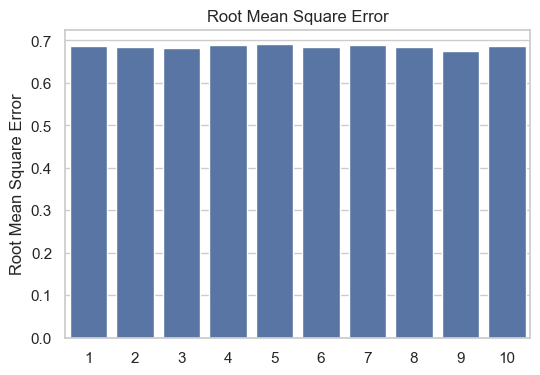

,movieId,title,predicted_rating,actual_rating
254,44191,Revengeance,4.090764,0
301,31410,Sugar,3.969745,0
205,26974,House Party 4: Down to the Last Minute,3.911537,0
244,32387,29th and Gay,3.773267,0
11,2108,Elstree Calling,3.772967,0
50,26578,The Trans-Atlantic Mystery,3.756465,0
135,1884,Child's Play 3,3.730681,0
193,4180,Moulin Rouge!,3.721052,0
269,30723,He-Man and She-Ra: The Secret of the Sword,3.715264,0
48,1694,U.S. Marshals,3.702606,0


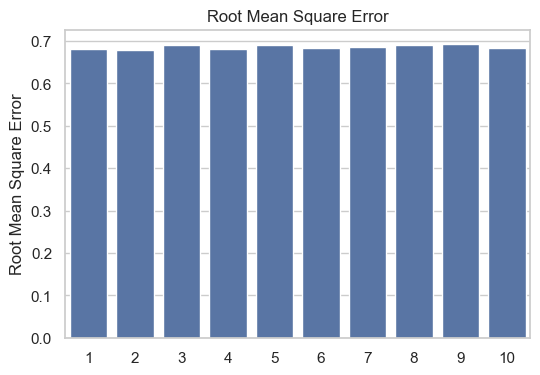

In [427]:
# Entfernen von IDs welche fehlerhaft sind
df_meta = metadata.drop([19730, 29503, 35587])

df_movies = getDfMovies(df_meta)
svd_model_trained = trainAndValidateCollaboration(rating)

title = 'The Dark Knight Rises'
user_id = 400
n = 10

# Ausgabe anhand vom collaborativen Filter
recommend_films_by_collaboration(title, n, user_id, svd_model_trained, df_movies, rating)